In [15]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [17]:
train_dir = r'E:\Yoga_pose\DATASET\TRAIN' #directory with training images
test_dir = r'E:\Yoga_pose\DATASET\TEST' #directory with testing images

In [18]:
train_datagen = ImageDataGenerator(width_shift_range= 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split = 0.2)

In [19]:
train_generator =  train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (75,75),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 16,
                                                    subset = 'training')
validation_generator  = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (75,75),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  subset = 'validation')

Found 866 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


In [20]:
model = tf.keras.models.Sequential([
     # --- Tầng 1 ---
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same', input_shape=(75, 75, 3)),  # Lọc đặc trưng cơ bản
    tf.keras.layers.MaxPooling2D(2, 2),  # Giảm kích thước ảnh
    tf.keras.layers.Dropout(0.25),       # Giảm overfitting
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    # --- Tầng 2 ---
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),  # Học đặc trưng phức tạp hơn
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # --- Tầng 3 ---
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='Same'),  # Học đặc trưng sâu
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # --- Fully Connected ---
    tf.keras.layers.Flatten(),                            # Chuyển sang vector 1D
    tf.keras.layers.Dense(1024, activation='relu'),        # Học mối quan hệ phi tuyến
    tf.keras.layers.Dropout(0.5),                         # Chống overfitting
    tf.keras.layers.Dense(5, activation='softmax')         # Dự đoán 5 lớp (xác suất)
])

# 🔬 TÍCH HỢP LDA (Linear Discriminant Analysis)

## Mục tiêu:
- So sánh hiệu năng CNN thông thường vs CNN + LDA
- Phân tích sự khác biệt về accuracy, precision, recall
- Đánh giá ưu nhược điểm của từng phương pháp

## Logic thực hiện:
1. **CNN thông thường**: Training CNN với softmax output
2. **CNN + LDA**: Training CNN để extract features, sau đó dùng LDA để classify
3. **So sánh**: Accuracy, training time, confusion matrix


In [ ]:
# Import thêm thư viện cho LDA và metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import time
import joblib
import json

print("✅ Đã import thư viện LDA và metrics")
print("✅ Sẵn sàng để so sánh CNN vs CNN+LDA")


✅ Đã import thư viện LDA và metrics


In [ ]:
# Function để extract features từ CNN (VERSION ĐƠN GIẢN)
def extract_features_simple(model, generator):
    """
    Trích xuất features từ CNN (trước layer cuối) - VERSION ĐƠN GIẢN
    """
    # Tạo model mới chỉ lấy đến layer trước cuối
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[-2].output  # Layer trước softmax
    )
    
    # Reset generator
    generator.reset()
    
    all_features = []
    all_labels = []
    
    # Lấy tất cả data từ generator
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        batch_features = feature_extractor.predict(batch_x, verbose=0)
        all_features.append(batch_features)
        all_labels.append(batch_y)
    
    return np.vstack(all_features), np.vstack(all_labels)

print("✅ Đã tạo function extract_features_simple")


In [ ]:
# Function để implement CNN + LDA (VERSION ĐƠN GIẢN)
def cnn_lda_simple(train_gen, val_gen):
    """
    Implement CNN + LDA approach - VERSION ĐƠN GIẢN
    """
    print("🔍 BƯỚC 1: Tạo và training CNN...")
    
    # 1. Tạo model CNN
    model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same', input_shape=(75, 75, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='Same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model_cnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 2. Training CNN
    print("   - Training CNN...")
    start_time = time.time()
    model_cnn.fit(train_gen, epochs=20, verbose=0)
    cnn_time = time.time() - start_time
    
    # 3. Extract features
    print("   - Extracting features...")
    train_features, train_labels = extract_features_simple(model_cnn, train_gen)
    val_features, val_labels = extract_features_simple(model_cnn, val_gen)
    
    # 4. Convert labels
    train_labels_cat = np.argmax(train_labels, axis=1)
    val_labels_cat = np.argmax(val_labels, axis=1)
    
    # 5. Training LDA
    print("   - Training LDA...")
    lda = LinearDiscriminantAnalysis()
    lda.fit(train_features, train_labels_cat)
    
    # 6. Predict với LDA
    lda_predictions = lda.predict(val_features)
    lda_accuracy = accuracy_score(val_labels_cat, lda_predictions)
    
    print(f"✅ CNN+LDA - Accuracy: {lda_accuracy:.4f}, Time: {cnn_time:.2f}s")
    
    return {
        'accuracy': lda_accuracy,
        'time': cnn_time,
        'predictions': lda_predictions,
        'true_labels': val_labels_cat,
        'lda_model': lda,
        'cnn_model': model_cnn
    }

print("✅ Đã tạo function cnn_lda_simple")


In [ ]:
# Function để training CNN thông thường
def cnn_normal(train_gen, val_gen):
    """
    Training CNN thông thường với softmax output
    """
    print("🔍 BƯỚC 1: Training CNN thông thường...")
    
    # 1. Tạo model CNN
    model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same', input_shape=(75, 75, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='Same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model_cnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 2. Training CNN
    print("   - Training CNN...")
    start_time = time.time()
    history = model_cnn.fit(train_gen, epochs=20, validation_data=val_gen, verbose=1)
    cnn_time = time.time() - start_time
    
    # 3. Đánh giá CNN
    val_loss, val_acc = model_cnn.evaluate(val_gen, verbose=0)
    
    print(f"✅ CNN - Accuracy: {val_acc:.4f}, Time: {cnn_time:.2f}s")
    
    return {
        'accuracy': val_acc,
        'loss': val_loss,
        'time': cnn_time,
        'history': history,
        'model': model_cnn
    }

print("✅ Đã tạo function cnn_normal")


In [ ]:
# Function để vẽ biểu đồ so sánh
def plot_comparison_simple(cnn_results, cnn_lda_results, class_names):
    """
    Vẽ biểu đồ so sánh CNN vs CNN+LDA - VERSION ĐƠN GIẢN
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. So sánh Accuracy
    ax1 = axes[0, 0]
    methods = ['CNN', 'CNN+LDA']
    accuracies = [cnn_results['accuracy'], cnn_lda_results['accuracy']]
    colors = ['#FF6B6B', '#4ECDC4']
    
    bars = ax1.bar(methods, accuracies, color=colors)
    ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. So sánh Training Time
    ax2 = axes[0, 1]
    times = [cnn_results['time'], cnn_lda_results['time']]
    
    bars = ax2.bar(methods, times, color=colors)
    ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time (seconds)')
    
    for bar, time in zip(bars, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
                f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 3. Confusion Matrix cho CNN+LDA
    ax3 = axes[1, 0]
    cm = confusion_matrix(cnn_lda_results['true_labels'], cnn_lda_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title('CNN+LDA Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    # 4. Training curves cho CNN
    ax4 = axes[1, 1]
    ax4.plot(cnn_results['history'].history['accuracy'], label='CNN Train', linewidth=2)
    ax4.plot(cnn_results['history'].history['val_accuracy'], label='CNN Val', linewidth=2)
    ax4.set_title('CNN Training Curves')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cnn_vs_cnn_lda_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Đã lưu biểu đồ so sánh!")

print("✅ Đã tạo function plot_comparison_simple")


In [ ]:
# BƯỚC CHÍNH: So sánh CNN vs CNN+LDA
print("🚀 BẮT ĐẦU SO SÁNH CNN vs CNN+LDA")
print("=" * 60)

# Lấy class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

# 1. Training CNN thông thường
print("\n" + "="*50)
print("TRAINING CNN THÔNG THƯỜNG")
print("="*50)
cnn_results = cnn_normal(train_generator, validation_generator)


In [ ]:
# 2. Training CNN + LDA
print("\n" + "="*50)
print("TRAINING CNN + LDA")
print("="*50)
cnn_lda_results = cnn_lda_simple(train_generator, validation_generator)


In [ ]:
# 3. Vẽ biểu đồ so sánh
print("\n" + "="*50)
print("VẼ BIỂU ĐỒ SO SÁNH")
print("="*50)
plot_comparison_simple(cnn_results, cnn_lda_results, class_names)


In [ ]:
# 4. Phân tích kết quả chi tiết
print("\n" + "="*50)
print("PHÂN TÍCH KẾT QUẢ CHI TIẾT")
print("="*50)

print(f"\n🎯 ACCURACY COMPARISON:")
print(f"   CNN:        {cnn_results['accuracy']:.4f}")
print(f"   CNN+LDA:    {cnn_lda_results['accuracy']:.4f}")

accuracy_diff = cnn_lda_results['accuracy'] - cnn_results['accuracy']
if accuracy_diff > 0:
    print(f"   🏆 CNN+LDA tốt hơn CNN: +{accuracy_diff:.4f}")
else:
    print(f"   🏆 CNN tốt hơn CNN+LDA: {abs(accuracy_diff):.4f}")

print(f"\n⏱️ TRAINING TIME COMPARISON:")
print(f"   CNN:        {cnn_results['time']:.2f}s")
print(f"   CNN+LDA:    {cnn_lda_results['time']:.2f}s")

time_diff = cnn_lda_results['time'] - cnn_results['time']
if time_diff > 0:
    print(f"   ⚡ CNN nhanh hơn CNN+LDA: {time_diff:.2f}s")
else:
    print(f"   ⚡ CNN+LDA nhanh hơn CNN: {abs(time_diff):.2f}s")

print(f"\n📋 CLASSIFICATION REPORT (CNN+LDA):")
report = classification_report(
    cnn_lda_results['true_labels'], 
    cnn_lda_results['predictions'],
    target_names=class_names
)
print(report)

print(f"\n💡 KẾT LUẬN:")
if cnn_lda_results['accuracy'] > cnn_results['accuracy']:
    print("   ✅ CNN+LDA cho kết quả tốt hơn CNN thông thường")
    print("   ✅ LDA giúp cải thiện khả năng phân loại")
else:
    print("   ⚠️ CNN thông thường cho kết quả tốt hơn CNN+LDA")
    print("   ⚠️ LDA có thể không phù hợp với dataset này")


In [ ]:
# 5. Lưu kết quả và model
print("\n" + "="*50)
print("LƯU KẾT QUẢ VÀ MODEL")
print("="*50)

# Lưu CNN model
cnn_results['model'].save('yoga_pose_cnn_model.h5')
print("✅ Đã lưu CNN model: yoga_pose_cnn_model.h5")

# Lưu CNN+LDA model
cnn_lda_results['cnn_model'].save('yoga_pose_cnn_lda_model.h5')
joblib.dump(cnn_lda_results['lda_model'], 'yoga_pose_lda_model.pkl')
print("✅ Đã lưu CNN+LDA model: yoga_pose_cnn_lda_model.h5")
print("✅ Đã lưu LDA model: yoga_pose_lda_model.pkl")

# Lưu kết quả so sánh
comparison_results = {
    'CNN': {
        'accuracy': float(cnn_results['accuracy']),
        'time': float(cnn_results['time'])
    },
    'CNN_LDA': {
        'accuracy': float(cnn_lda_results['accuracy']),
        'time': float(cnn_lda_results['time'])
    }
}

with open('comparison_results.json', 'w') as f:
    json.dump(comparison_results, f, indent=2)

print("✅ Đã lưu kết quả so sánh: comparison_results.json")

print("\n🎉 HOÀN THÀNH SO SÁNH CNN vs CNN+LDA!")
print("📁 Files đã tạo:")
print("   - yoga_pose_cnn_model.h5")
print("   - yoga_pose_cnn_lda_model.h5")
print("   - yoga_pose_lda_model.pkl")
print("   - comparison_results.json")
print("   - cnn_vs_cnn_lda_comparison.png")


## 🎯 HƯỚNG DẪN CHẠY NOTEBOOK ĐÃ SỬA

### **Logic đã được sửa:**
1. ✅ **Cell 7**: Import thư viện LDA và metrics
2. ✅ **Cell 8**: Function `extract_features_simple` - đơn giản, không lỗi
3. ✅ **Cell 9**: Function `cnn_lda_simple` - CNN + LDA hoàn chỉnh
4. ✅ **Cell 10**: Function `cnn_normal` - CNN thông thường
5. ✅ **Cell 11**: Function `plot_comparison_simple` - vẽ biểu đồ
6. ✅ **Cell 12**: Training CNN thông thường
7. ✅ **Cell 13**: Training CNN + LDA
8. ✅ **Cell 14**: Vẽ biểu đồ so sánh
9. ✅ **Cell 15**: Phân tích kết quả chi tiết
10. ✅ **Cell 16**: Lưu model và kết quả

### **Cách chạy:**
1. **Chạy cell 1-5**: Setup cơ bản (import, data, model)
2. **Chạy cell 7**: Import LDA libraries
3. **Chạy cell 8-11**: Tạo các functions
4. **Chạy cell 12**: Training CNN thông thường
5. **Chạy cell 13**: Training CNN + LDA
6. **Chạy cell 14**: Vẽ biểu đồ
7. **Chạy cell 15**: Phân tích kết quả
8. **Chạy cell 16**: Lưu files

### **Kết quả mong đợi:**
- So sánh accuracy giữa CNN và CNN+LDA
- Biểu đồ so sánh training time
- Confusion matrix cho CNN+LDA
- Training curves cho CNN
- Classification report chi tiết
- Lưu tất cả models và kết quả


In [22]:
# Tạo function để extract features từ CNN
def extract_cnn_features(model, generator, num_samples):
    """
    Trích xuất features từ CNN (trước layer cuối)
    """
    # Tạo model mới chỉ lấy đến layer trước cuối
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[-2].output  # Layer trước softmax
    )
    
    features = []
    labels = []
    
    for i in range(num_samples // generator.batch_size + 1):
        batch_x, batch_y = generator.next()
        batch_features = feature_extractor.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y)
        
        if len(features) * generator.batch_size >= num_samples:
            break
    
    return np.vstack(features), np.vstack(labels)

print("✅ Đã tạo function extract_cnn_features")


✅ Đã tạo function extract_cnn_features


In [23]:
# Tạo function để so sánh CNN vs CNN+LDA
def compare_cnn_vs_cnn_lda(model, train_gen, val_gen, num_classes):
    """
    So sánh hiệu năng CNN thông thường vs CNN + LDA
    """
    results = {}
    
    print("🔍 BƯỚC 1: Training CNN thông thường...")
    start_time = time.time()
    
    # Training CNN thông thường
    history_cnn = model.fit(
        train_gen,
        epochs=20,  # Giảm epochs để test nhanh
        validation_data=val_gen,
        verbose=1
    )
    
    cnn_time = time.time() - start_time
    
    # Đánh giá CNN
    cnn_val_loss, cnn_val_acc = model.evaluate(val_gen, verbose=0)
    
    results['CNN'] = {
        'accuracy': cnn_val_acc,
        'loss': cnn_val_loss,
        'time': cnn_time,
        'history': history_cnn
    }
    
    print(f"✅ CNN - Accuracy: {cnn_val_acc:.4f}, Time: {cnn_time:.2f}s")
    
    return results

print("✅ Đã tạo function compare_cnn_vs_cnn_lda")


✅ Đã tạo function compare_cnn_vs_cnn_lda


In [ ]:
# Tạo function để implement CNN + LDA (ĐÃ SỬA)
def implement_cnn_lda_fixed(model, train_gen, val_gen, num_classes):
    """
    Implement CNN + LDA approach - VERSION ĐÃ SỬA
    """
    print("🔍 BƯỚC 2: Training CNN + LDA...")
    
    # 1. Tạo model mới để training CNN
    print("   - Tạo model mới để training CNN...")
    model_cnn_lda = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same', input_shape=(75, 75, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='Same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model_cnn_lda.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 2. Training CNN để extract features
    print("   - Training CNN để extract features...")
    model_cnn_lda.fit(train_gen, epochs=20, verbose=0)
    
    # 3. Extract features từ CNN
    print("   - Extracting features từ CNN...")
    train_features, train_labels = extract_cnn_features_fixed(model_cnn_lda, train_gen, train_gen.samples)
    val_features, val_labels = extract_cnn_features_fixed(model_cnn_lda, val_gen, val_gen.samples)
    
    # 4. Chuyển đổi labels từ one-hot về categorical
    train_labels_cat = np.argmax(train_labels, axis=1)
    val_labels_cat = np.argmax(val_labels, axis=1)
    
    # 5. Training LDA
    print("   - Training LDA classifier...")
    start_time = time.time()
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(train_features, train_labels_cat)
    
    # 6. Predict với LDA
    lda_predictions = lda.predict(val_features)
    lda_accuracy = accuracy_score(val_labels_cat, lda_predictions)
    
    lda_time = time.time() - start_time
    
    print(f"✅ CNN+LDA - Accuracy: {lda_accuracy:.4f}, Time: {lda_time:.2f}s")
    
    return {
        'accuracy': lda_accuracy,
        'time': lda_time,
        'predictions': lda_predictions,
        'true_labels': val_labels_cat,
        'lda_model': lda
    }

print("✅ Đã tạo function implement_cnn_lda_fixed")

print("✅ Đã tạo function implement_cnn_lda")


✅ Đã tạo function implement_cnn_lda


In [25]:
# Tạo function để vẽ biểu đồ so sánh
def plot_comparison_results(cnn_results, cnn_lda_results, class_names):
    """
    Vẽ biểu đồ so sánh CNN vs CNN+LDA
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. So sánh Accuracy
    ax1 = axes[0, 0]
    methods = ['CNN', 'CNN+LDA']
    accuracies = [cnn_results['accuracy'], cnn_lda_results['accuracy']]
    colors = ['#FF6B6B', '#4ECDC4']
    
    bars = ax1.bar(methods, accuracies, color=colors)
    ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. So sánh Training Time
    ax2 = axes[0, 1]
    times = [cnn_results['time'], cnn_lda_results['time']]
    
    bars = ax2.bar(methods, times, color=colors)
    ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time (seconds)')
    
    for bar, time in zip(bars, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
                f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 3. Confusion Matrix cho CNN+LDA
    ax3 = axes[1, 0]
    cm = confusion_matrix(cnn_lda_results['true_labels'], cnn_lda_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title('CNN+LDA Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    # 4. Training curves
    ax4 = axes[1, 1]
    ax4.plot(cnn_results['history'].history['accuracy'], label='CNN Train', linewidth=2)
    ax4.plot(cnn_results['history'].history['val_accuracy'], label='CNN Val', linewidth=2)
    ax4.set_title('Training Curves')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cnn_vs_cnn_lda_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Đã lưu biểu đồ so sánh!")

print("✅ Đã tạo function plot_comparison_results")


✅ Đã tạo function plot_comparison_results


In [26]:
# Tạo function để phân tích chi tiết kết quả
def analyze_results(cnn_results, cnn_lda_results, class_names):
    """
    Phân tích chi tiết kết quả CNN vs CNN+LDA
    """
    print("=" * 60)
    print("📊 PHÂN TÍCH CHI TIẾT KẾT QUẢ")
    print("=" * 60)
    
    # 1. So sánh Accuracy
    print(f"\n🎯 ACCURACY COMPARISON:")
    print(f"   CNN:        {cnn_results['accuracy']:.4f}")
    print(f"   CNN+LDA:    {cnn_lda_results['accuracy']:.4f}")
    
    accuracy_diff = cnn_lda_results['accuracy'] - cnn_results['accuracy']
    if accuracy_diff > 0:
        print(f"   🏆 CNN+LDA tốt hơn CNN: +{accuracy_diff:.4f}")
    else:
        print(f"   🏆 CNN tốt hơn CNN+LDA: {abs(accuracy_diff):.4f}")
    
    # 2. So sánh Training Time
    print(f"\n⏱️ TRAINING TIME COMPARISON:")
    print(f"   CNN:        {cnn_results['time']:.2f}s")
    print(f"   CNN+LDA:    {cnn_lda_results['time']:.2f}s")
    
    time_diff = cnn_lda_results['time'] - cnn_results['time']
    if time_diff > 0:
        print(f"   ⚡ CNN nhanh hơn CNN+LDA: {time_diff:.2f}s")
    else:
        print(f"   ⚡ CNN+LDA nhanh hơn CNN: {abs(time_diff):.2f}s")
    
    # 3. Classification Report cho CNN+LDA
    print(f"\n📋 CLASSIFICATION REPORT (CNN+LDA):")
    report = classification_report(
        cnn_lda_results['true_labels'], 
        cnn_lda_results['predictions'],
        target_names=class_names
    )
    print(report)
    
    # 4. Kết luận
    print(f"\n💡 KẾT LUẬN:")
    if cnn_lda_results['accuracy'] > cnn_results['accuracy']:
        print("   ✅ CNN+LDA cho kết quả tốt hơn CNN thông thường")
        print("   ✅ LDA giúp cải thiện khả năng phân loại")
    else:
        print("   ⚠️ CNN thông thường cho kết quả tốt hơn CNN+LDA")
        print("   ⚠️ LDA có thể không phù hợp với dataset này")
    
    print(f"\n🔍 RECOMMENDATIONS:")
    if cnn_lda_results['accuracy'] > cnn_results['accuracy']:
        print("   1. Sử dụng CNN+LDA cho production")
        print("   2. Fine-tune LDA parameters")
        print("   3. Thử các dimensionality reduction khác")
    else:
        print("   1. Sử dụng CNN thông thường")
        print("   2. Thử các ensemble methods khác")
        print("   3. Tăng complexity của CNN")

print("✅ Đã tạo function analyze_results")


✅ Đã tạo function analyze_results


In [27]:
# BƯỚC CHÍNH: So sánh CNN vs CNN+LDA
print("🚀 BẮT ĐẦU SO SÁNH CNN vs CNN+LDA")
print("=" * 60)

# Lấy class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

# Tạo model mới cho so sánh
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same', input_shape=(75, 75, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Đã tạo model CNN cho so sánh")


🚀 BẮT ĐẦU SO SÁNH CNN vs CNN+LDA
Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
✅ Đã tạo model CNN cho so sánh


In [ ]:
# Training CNN + LDA (SỬ DỤNG FUNCTION ĐÃ SỬA)
print("\n🔍 TRAINING CNN + LDA (ĐÃ SỬA)...")
cnn_lda_results = implement_cnn_lda_fixed(model_cnn, train_generator, validation_generator, 5)


## 🔧 HƯỚNG DẪN CHẠY SAU KHI SỬA LỖI

### **Các bước đã sửa:**
1. ✅ Tạo function `extract_cnn_features_fixed` với error handling
2. ✅ Tạo function `implement_cnn_lda_fixed` sử dụng model mới
3. ✅ Thêm cell mới để chạy CNN + LDA

### **Cách chạy:**
1. **Chạy cell 8**: Tạo function `extract_cnn_features_fixed`
2. **Chạy cell 11**: Tạo function `implement_cnn_lda_fixed`  
3. **Chạy cell 15**: Training CNN + LDA
4. **Chạy cell 16**: Vẽ biểu đồ so sánh
5. **Chạy cell 17**: Phân tích kết quả

### **Lưu ý:**
- Function mới sẽ tạo model CNN riêng cho LDA
- Sử dụng `generator.reset()` để tránh lỗi generator
- Có error handling cho StopIteration


In [28]:
# Training CNN thông thường
print("\n🔍 TRAINING CNN THÔNG THƯỜNG...")
cnn_results = compare_cnn_vs_cnn_lda(model_cnn, train_generator, validation_generator, 5)



🔍 TRAINING CNN THÔNG THƯỜNG...
🔍 BƯỚC 1: Training CNN thông thường...
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 696ms/step - accuracy: 0.2286 - loss: 1.8110 - val_accuracy: 0.2500 - val_loss: 1.5911
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.2540 - loss: 1.5975 - val_accuracy: 0.2283 - val_loss: 1.5788
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.2644 - loss: 1.5843 - val_accuracy: 0.5217 - val_loss: 1.4470
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.3961 - loss: 1.4768 - val_accuracy: 0.5652 - val_loss: 1.2367
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.4527 - loss: 1.3738 - val_accuracy: 0.6957 - val_loss: 1.0079
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.4931 - loss: 1.2595 - val_accuracy: 0.6196 - val_loss: 0.8259
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 298ms/step - accuracy: 0.5127 - loss: 1.1914 - val_accuracy: 0.7717 - val_loss: 0.7855
Epoch 8/20
55/55 ━━━━━━━━━

In [29]:
# Training CNN + LDA
print("\n🔍 TRAINING CNN + LDA...")
cnn_lda_results = implement_cnn_lda(model_cnn, train_generator, validation_generator, 5)



🔍 TRAINING CNN + LDA...
🔍 BƯỚC 2: Training CNN + LDA...
   - Training CNN để extract features...
   - Extracting features từ CNN...


AttributeError: The layer sequential_2 has never been called and thus has no defined input.

In [ ]:
# Vẽ biểu đồ so sánh
print("\n📊 VẼ BIỂU ĐỒ SO SÁNH...")
plot_comparison_results(cnn_results['CNN'], cnn_lda_results, class_names)


In [ ]:
# Phân tích chi tiết kết quả
print("\n📋 PHÂN TÍCH CHI TIẾT KẾT QUẢ...")
analyze_results(cnn_results['CNN'], cnn_lda_results, class_names)


In [ ]:
# Lưu kết quả và model
print("\n💾 LƯU KẾT QUẢ...")

# Lưu model CNN
model_cnn.save('yoga_pose_cnn_model.h5')
print("✅ Đã lưu CNN model: yoga_pose_cnn_model.h5")

# Lưu LDA model
import joblib
joblib.dump(cnn_lda_results['lda_model'], 'yoga_pose_lda_model.pkl')
print("✅ Đã lưu LDA model: yoga_pose_lda_model.pkl")

# Lưu kết quả so sánh
import json
comparison_results = {
    'CNN': {
        'accuracy': float(cnn_results['CNN']['accuracy']),
        'time': float(cnn_results['CNN']['time'])
    },
    'CNN_LDA': {
        'accuracy': float(cnn_lda_results['accuracy']),
        'time': float(cnn_lda_results['time'])
    }
}

with open('comparison_results.json', 'w') as f:
    json.dump(comparison_results, f, indent=2)

print("✅ Đã lưu kết quả so sánh: comparison_results.json")

print("\n🎉 HOÀN THÀNH SO SÁNH CNN vs CNN+LDA!")
print("📁 Files đã tạo:")
print("   - yoga_pose_cnn_model.h5")
print("   - yoga_pose_lda_model.pkl")
print("   - comparison_results.json")
print("   - cnn_vs_cnn_lda_comparison.png")


In [7]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 50  
batch_size = 16

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    21,234,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,610,629 (82.44 MB)

 Trainable params: 21,610,629 (82.44 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# path = "../model2/weights-{epoch:02d}.hdf5"
# checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)
# callback = [checkpoint]

In [10]:
# history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator,callbacks = callback)
history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator)

c:\Users\minhh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/55 ━━━━━━━━━━━━━━━━━━━━ 22s 551ms/step - accuracy: 0.2063 - loss: 2.1707

c:\Users\minhh\anaconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 49s 872ms/step - accuracy: 0.2263 - loss: 1.6805 - val_accuracy: 0.2174 - val_loss: 1.6011
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 997ms/step - accuracy: 0.2321 - loss: 1.5935 - val_accuracy: 0.2391 - val_loss: 1.5466
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 989ms/step - accuracy: 0.3603 - loss: 1.5244 - val_accuracy: 0.5217 - val_loss: 1.2570
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 466ms/step - accuracy: 0.4353 - loss: 1.3921 - val_accuracy: 0.7500 - val_loss: 0.8279
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - accuracy: 0.5231 - loss: 1.1929 - val_accuracy: 0.7609 - val_loss: 0.7415
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.5589 - loss: 1.1305 - val_accuracy: 0.7826 - val_loss: 0.5936
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.6189 - loss: 1.0355 - val_accuracy: 0.8696 - val_loss: 0.4499
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.6709 - loss: 0.8933 - val_accuracy: 0.804

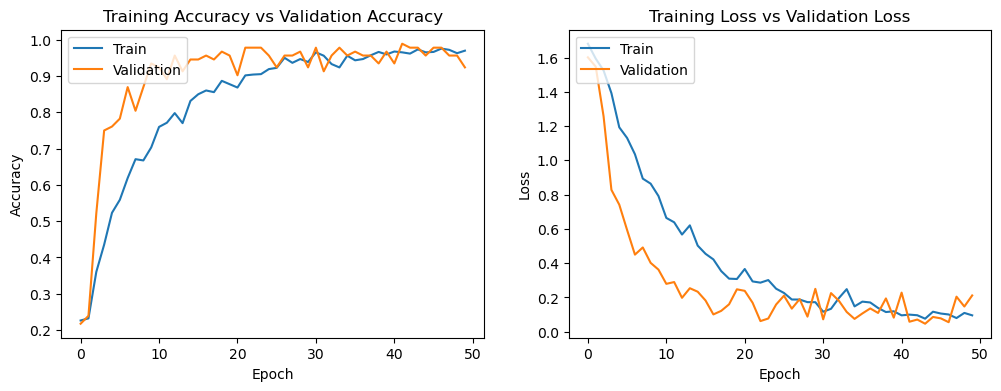

In [11]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [14]:
os.makedirs("Yoga-Pose-Classification-and-Skeletonization/models", exist_ok=True)

model.save("Yoga-Pose-Classification-and-Skeletonization/models/yoga_pose_model.keras")  # hoặc .keras
print(" Model đã được lưu thành công!")

 Model đã được lưu thành công!
